# Kaggle House Price Prediction with Advanced Regression Techniques

Inspired by https://medium.com/@permoonzz/kaggle-house-prices-advanced-regression-techniques-python-ensemble-learning%E5%AF%A6%E5%81%9A-99f757f4d326

##1 Setup

In [47]:
#!pip uninstall xgboost
#!pip install xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl

In [48]:
# import general libraries
import numpy as np
import pandas as pd
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# import sklearn modules
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

from xgboost.sklearn import XGBRegressor
from mlxtend.regressor import StackingRegressor

# import colab libraries
from google.colab import drive
drive.mount('/content/MyDrive/')

# ignore warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [49]:
sys.path.append('/content/MyDrive/MyDrive/Colab Notebooks/Kaggle Housing Price Prediction/data')

## 2 Prepare Data

In [50]:
# load data to dataframe
dataframe_train= pd.read_csv('/content/MyDrive/MyDrive/Colab Notebooks/Kaggle Housing Price Prediction/data/train.csv')
dataframe_test = pd.read_csv('/content/MyDrive/MyDrive/Colab Notebooks/Kaggle Housing Price Prediction/data/test.csv')

dataframe = pd.concat((dataframe_train, dataframe_test), sort=False).reset_index(drop=True)

## 3 Explorary Data Analysis

In [51]:
# explore numeric type columns
num_data = dataframe.select_dtypes(['int64', 'float64'])
describe_num = num_data.describe().transpose()
describe_num

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


In [52]:
num_data.columns.shape

(38,)

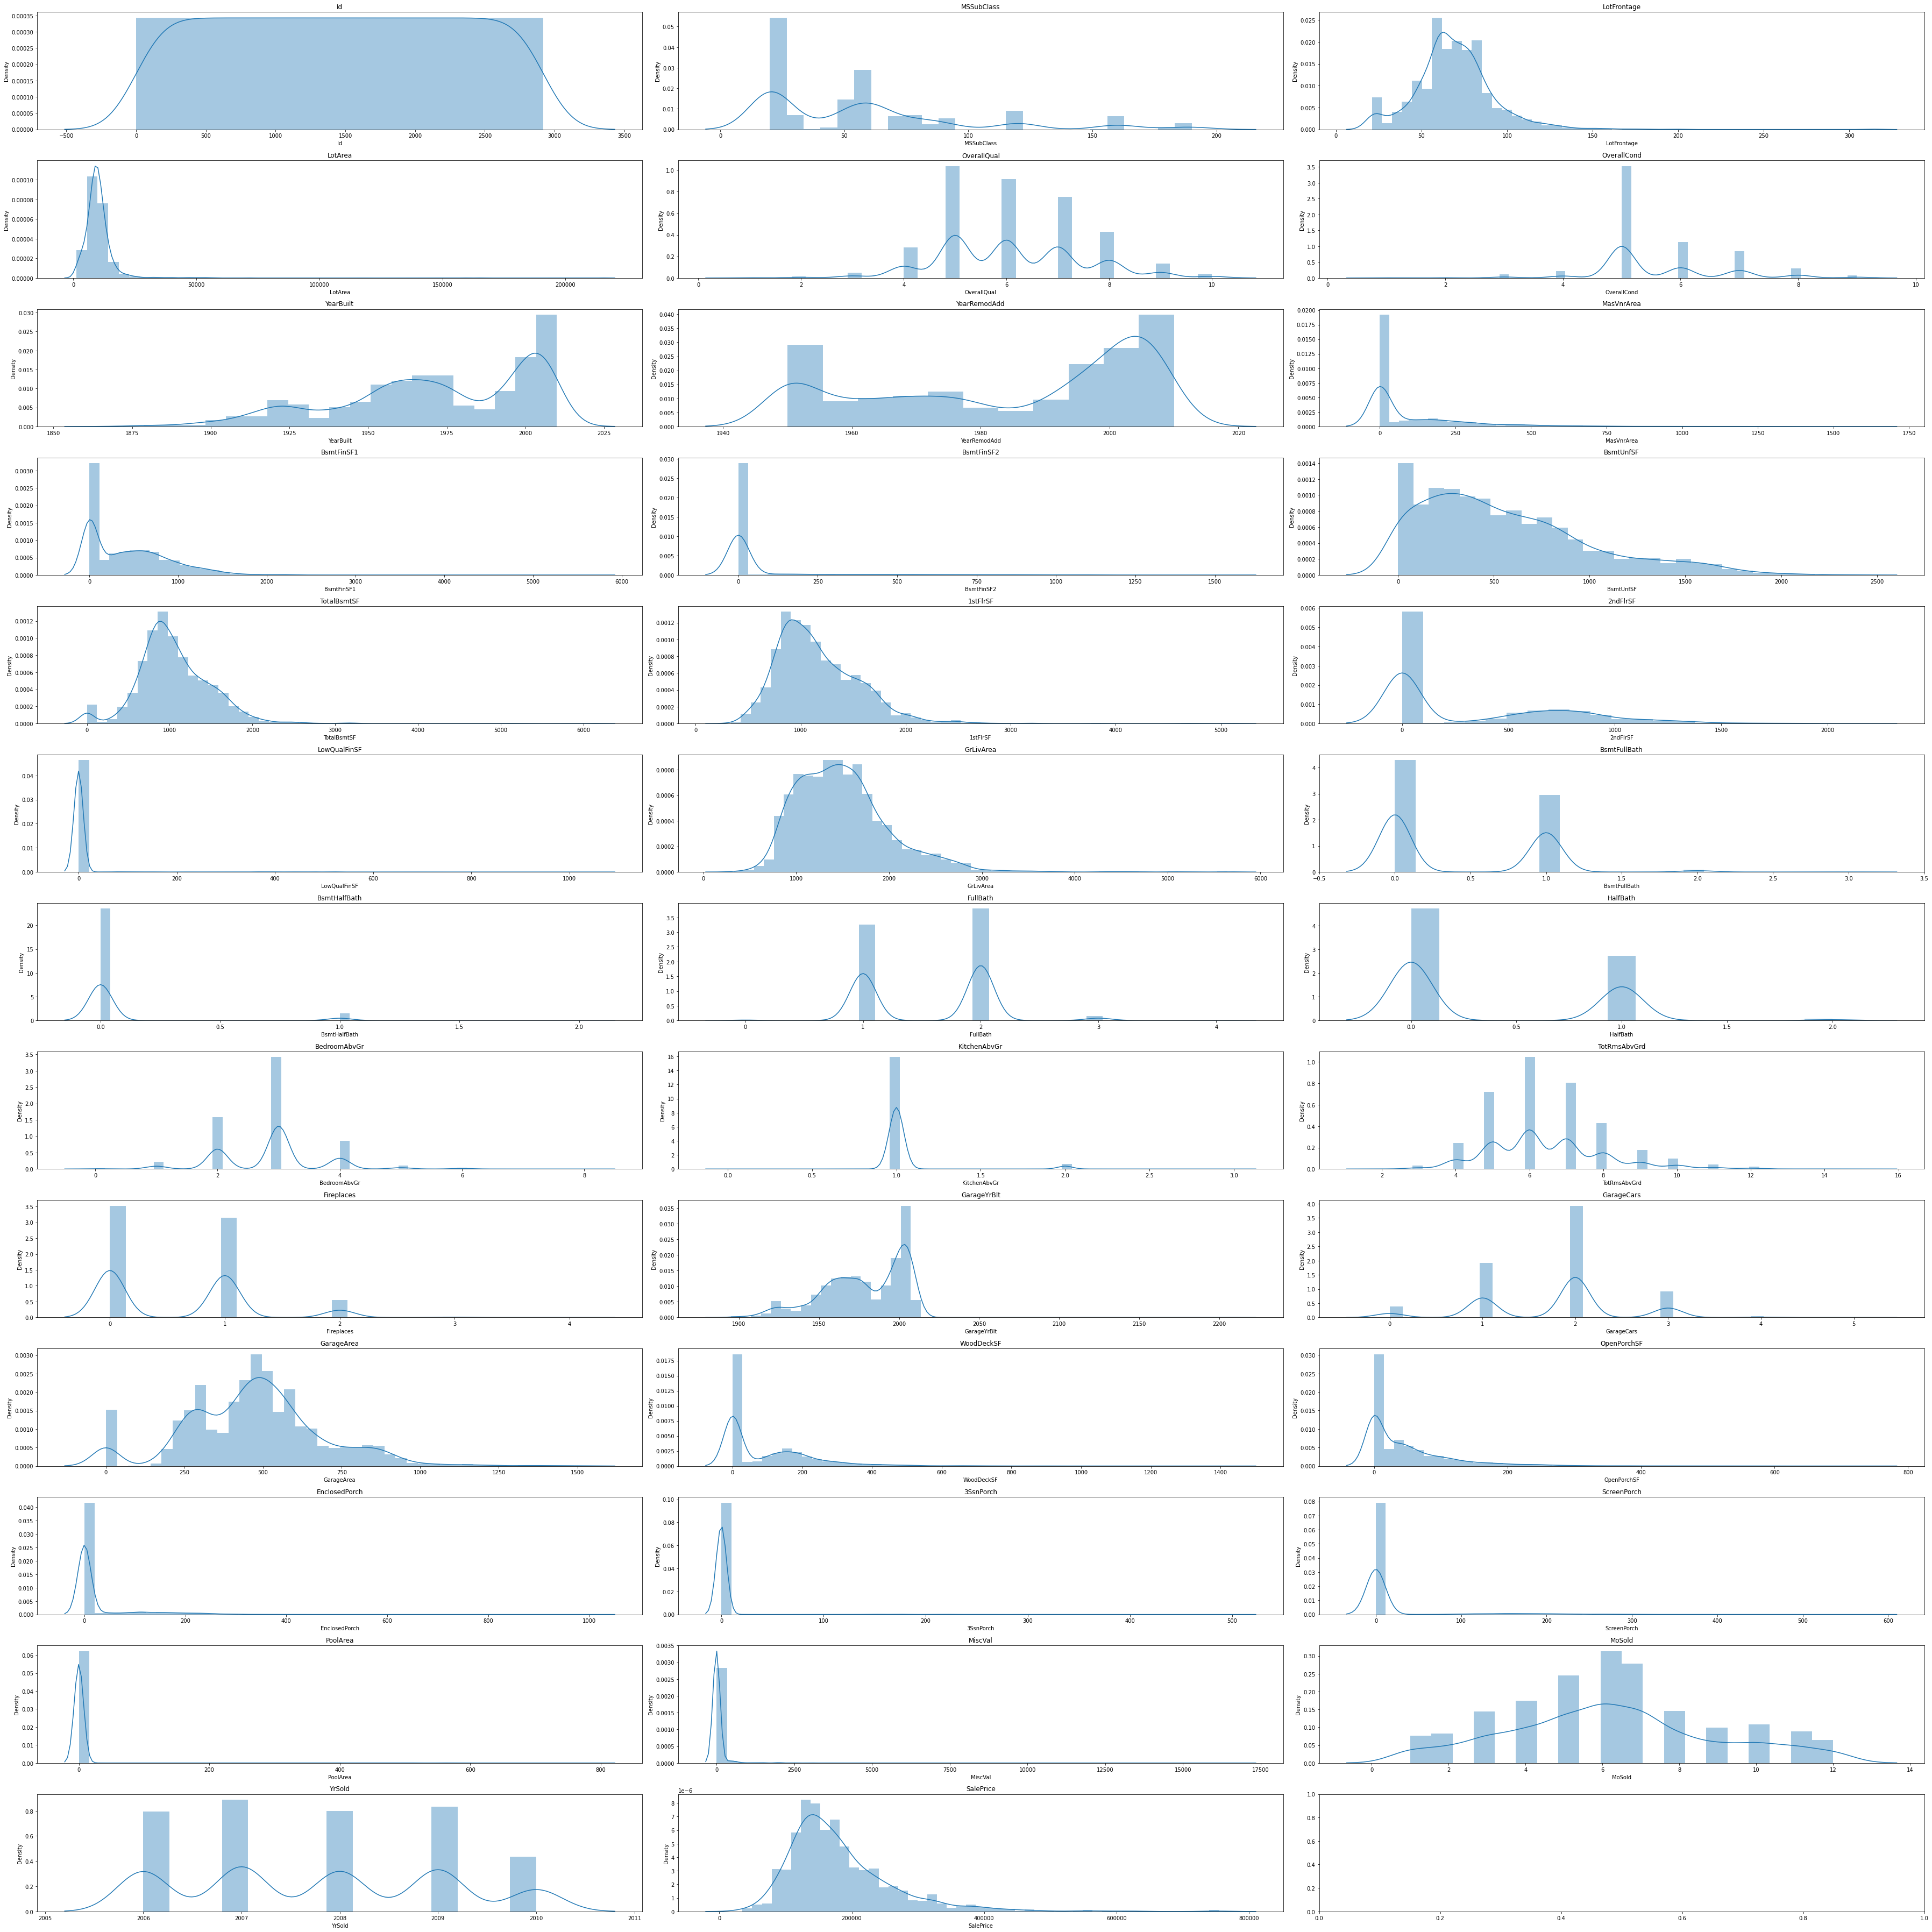

In [53]:
fig, axes = plt.subplots(13, 3, figsize=(50, 50))
axes = axes.ravel()

for i in range(len(axes)):
    if i < len(num_data.columns):
      col = num_data.columns[i]
      sns.distplot(num_data[col].dropna(), ax=axes[i]).set_title(col)
fig.tight_layout()

plt.show()

We can observe that 

1.   Some columns have extreme values
2.   Some columns comes with lots of zero



(array([0.5]), <a list of 1 Text major ticklabel objects>)

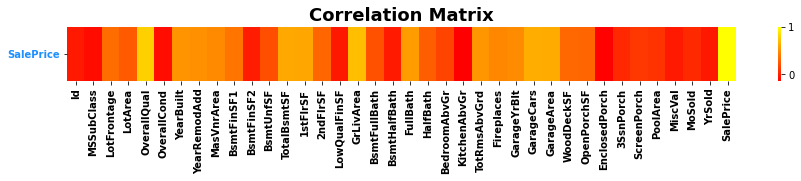

In [54]:
# correlation heatmap
num_train = dataframe_train.select_dtypes(['int64', 'float64'])
num_corr = num_train.corr().drop('Id')

fig, ax = plt.subplots(figsize=(15, 1))
sns.heatmap(num_corr.sort_values(by=[ 'SalePrice'], ascending=False).head(1), cmap = plt.cm.autumn)

plt.title("Correlation Matrix", weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)


In [55]:
num_corr['SalePrice'].sort_values(ascending=False).iloc[1:11]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

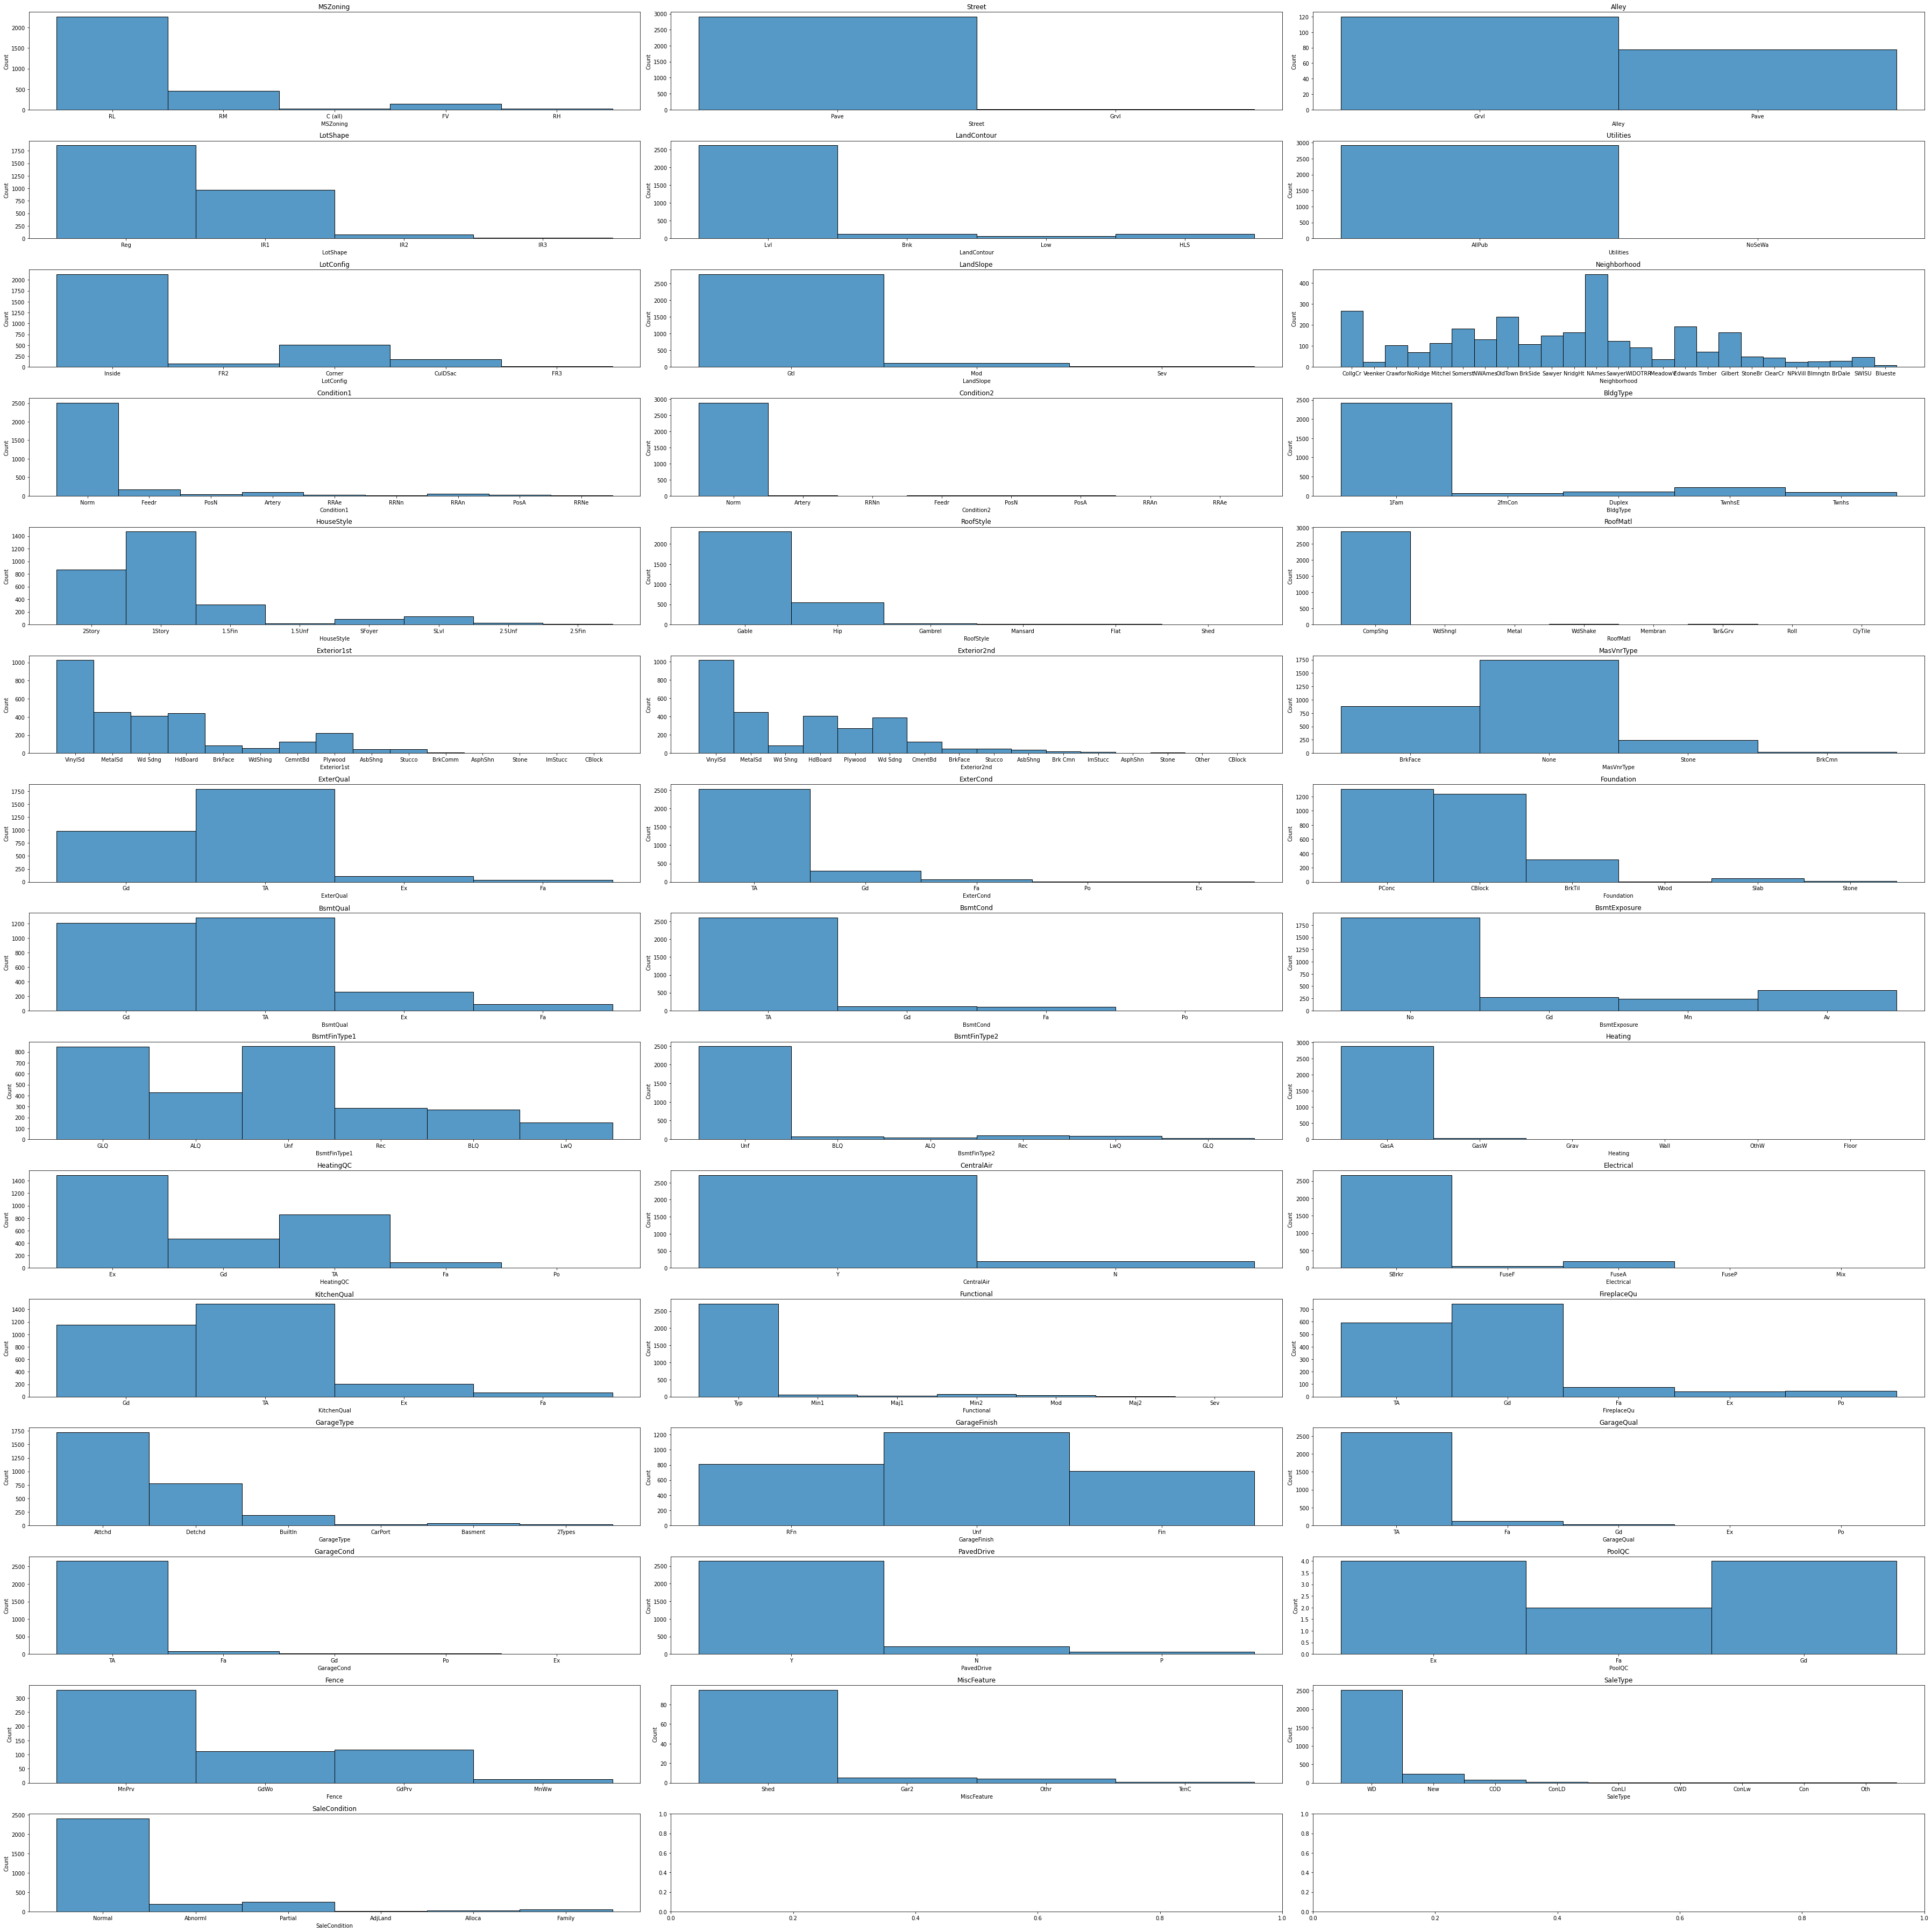

In [56]:
# explore object type columns
cat_data=dataframe.select_dtypes(['object'])

fig, axes = plt.subplots(15, 3, figsize=(50, 50))
axes = axes.ravel()

for i in range(len(axes)):
    if i < len(cat_data.columns):
      col = cat_data.columns[i]
      sns.histplot(cat_data[col].dropna(), ax=axes[i]).set_title(col)
fig.tight_layout()

plt.show()


Some columns are very biased (such as heating). We shall excluded those values when doing regression.

## 4 Data Preprocessing

### 4.1 Missing Value

         index         0
0       PoolQC  0.996574
1  MiscFeature  0.964029
2        Alley  0.932169
3        Fence  0.804385
4    SalePrice  0.499829


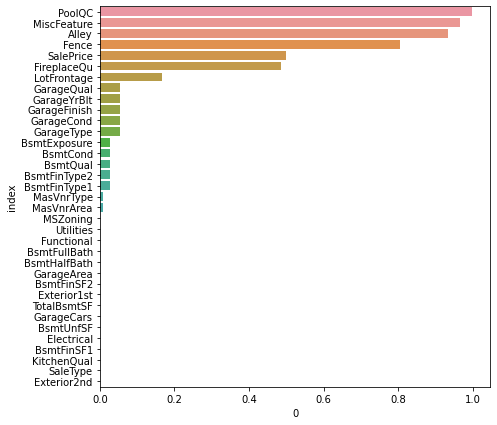

In [57]:
# deal with missing values
missing_columns = dataframe.isnull().mean().sort_values(ascending=False)
missing_columns = missing_columns[missing_columns !=0].to_frame().reset_index()
print(missing_columns.head())
fig,ax=plt.subplots(figsize=(7,7))
sns.barplot(x=0,y='index',data=missing_columns)

In [58]:
# drop columns with too many missing values
dataframe=dataframe.drop(columns=['Heating', 'RoofMatl', 'Condition2', 'Utilities', 'Street', 'PoolQC', 'MiscFeature', 'Alley', 'Fence'],
axis=1)

missing_cat=['FireplaceQu','GarageCond','GarageType','GarageFinish','GarageQual','BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual','MasVnrType','Electrical','MSZoning','Functional','Exterior1st','KitchenQual','Exterior2nd','SaleType']
missing_num=['LotFrontage','MasVnrArea','BsmtFullBath','BsmtHalfBath','TotalBsmtSF','GarageArea','BsmtUnfSF','BsmtFinSF2','GarageCars','BsmtFinSF1']


In [59]:
# for categorical variables, use none as default
for i in missing_cat:
    dataframe[i]=dataframe[i].fillna('none')

# for numerical variables, use 0 as default
for i in missing_num:
    dataframe[i]=dataframe[i].fillna(0)

dataframe['GarageYrBlt']=dataframe['GarageYrBlt'].fillna(dataframe['GarageYrBlt'].median())

### 4.2 Extreme Value

In [60]:
train_size = dataframe_train.shape[0]
train_size

1460

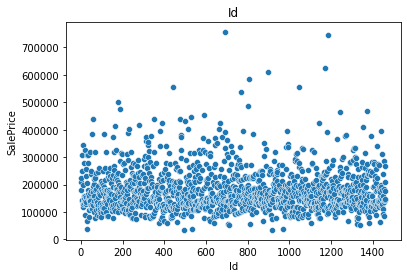

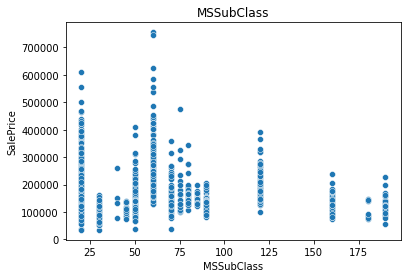

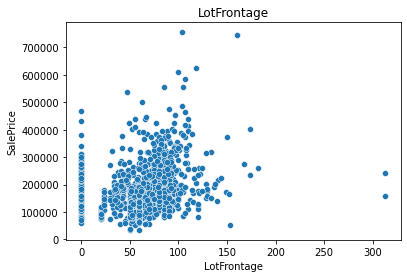

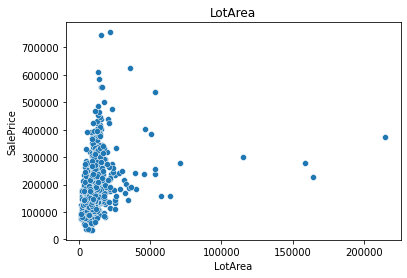

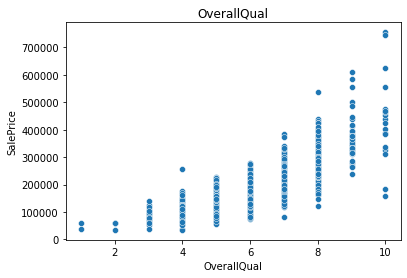

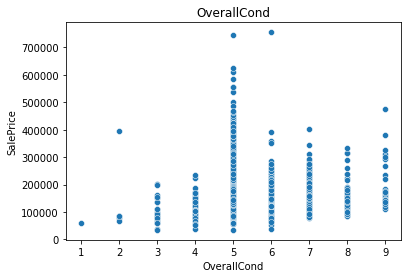

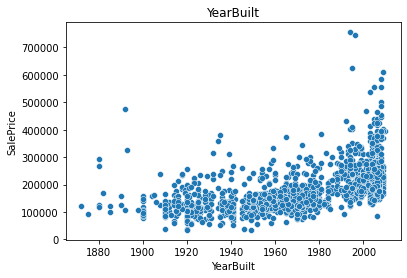

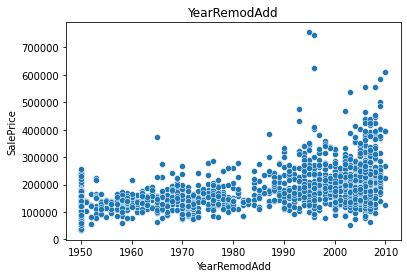

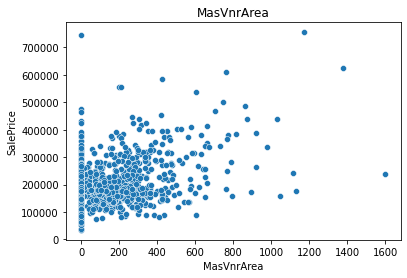

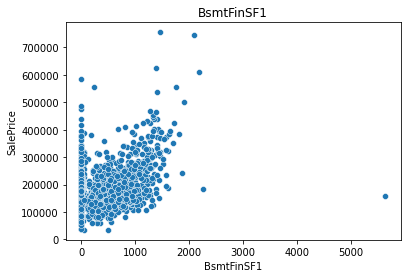

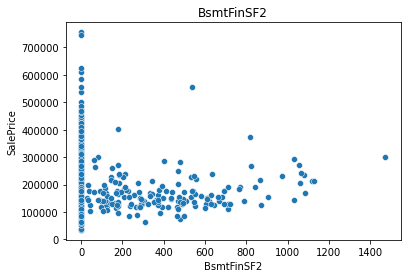

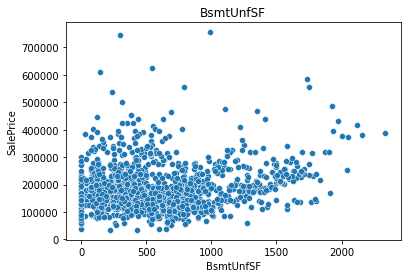

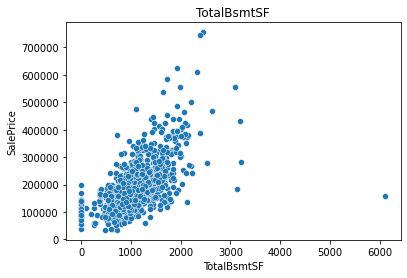

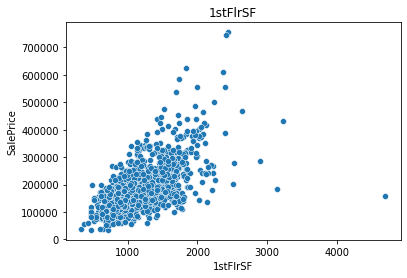

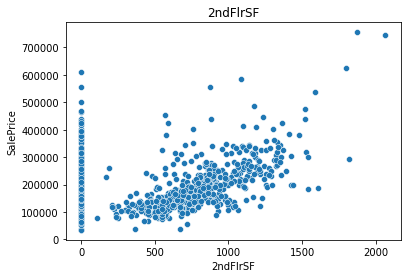

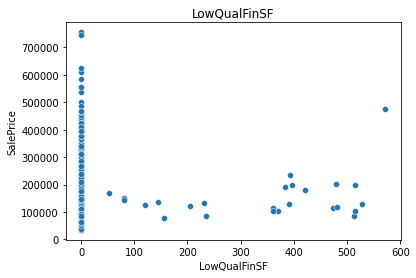

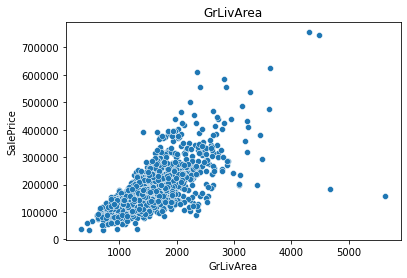

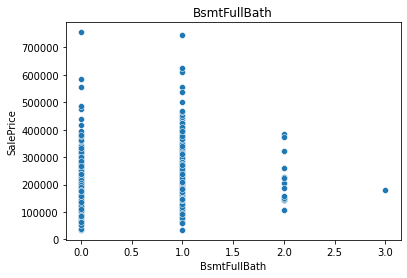

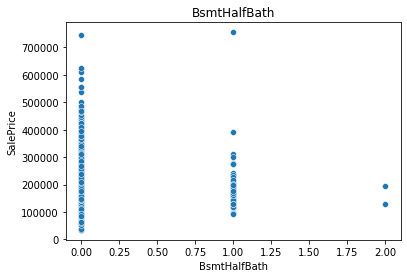

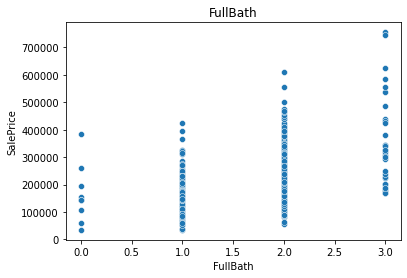

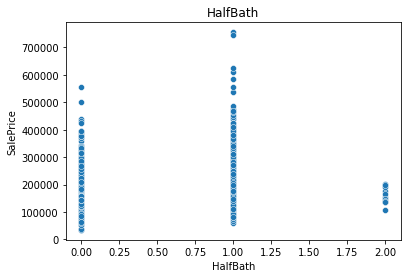

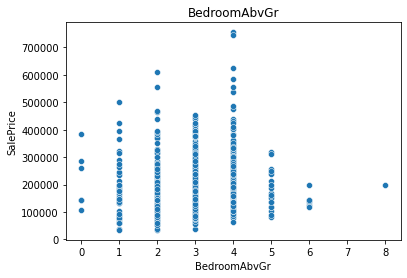

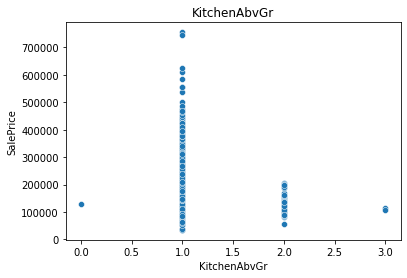

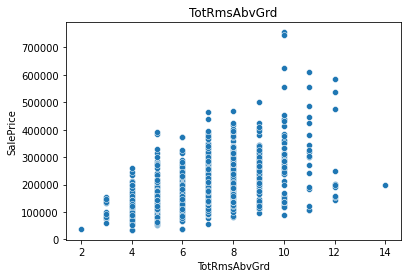

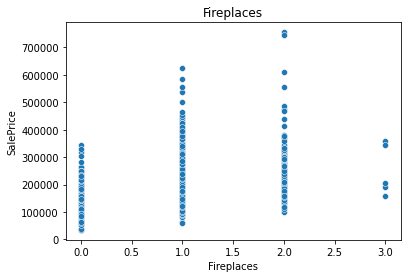

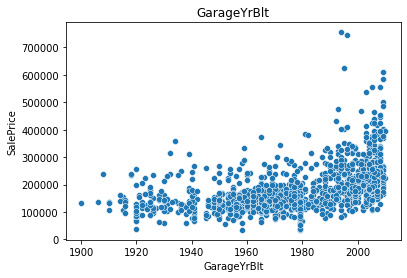

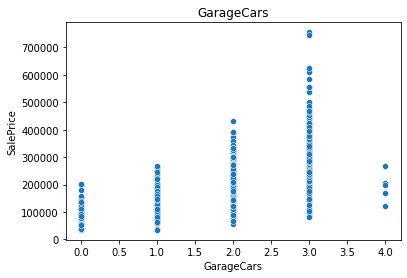

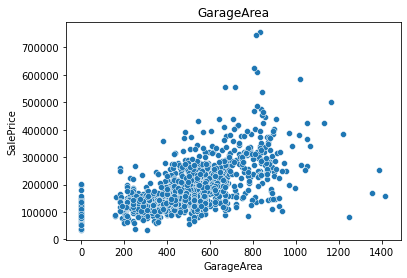

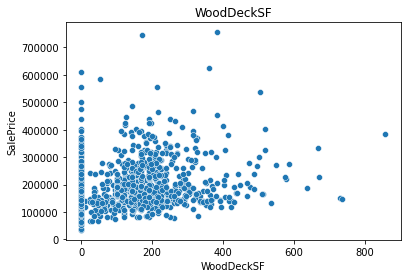

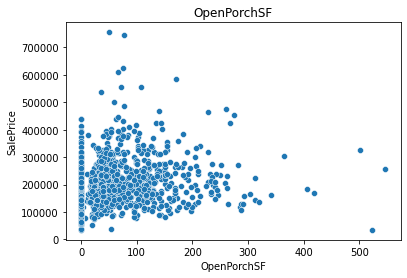

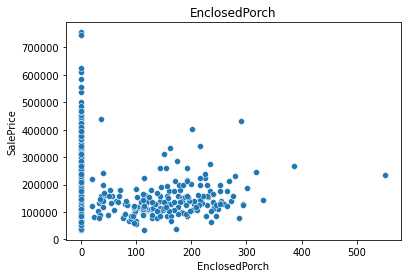

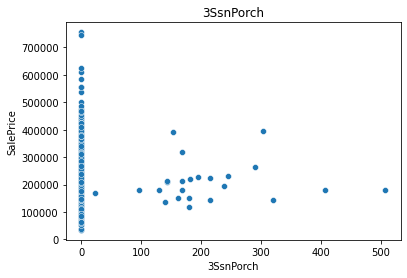

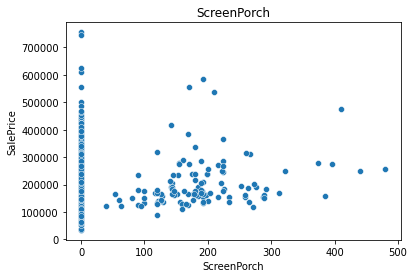

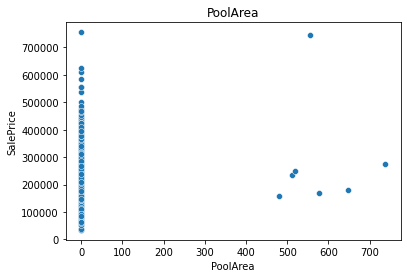

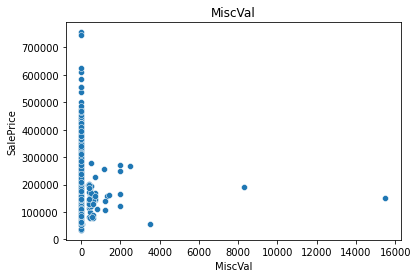

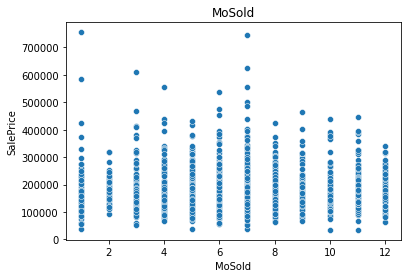

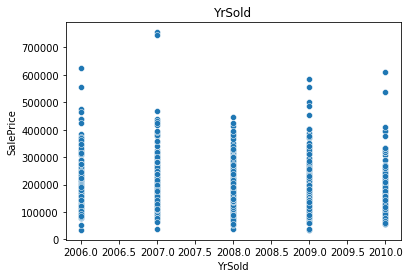

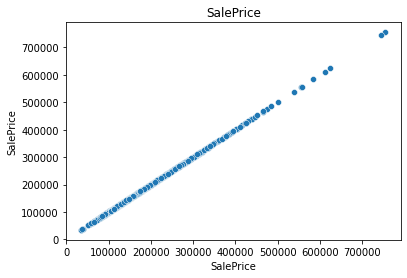

In [61]:
 # only remove outlier from training set
 data_remove_outlier = dataframe[:1460]

for col in num_train:
      sns.scatterplot(x=col, y='SalePrice', data=data_remove_outlier).set_title(col,fontsize=12,color='Black')
      plt.show()
      

In [62]:
outlier_columns=['LotFrontage','MasVnrArea','BsmtFinSF1','TotalBsmtSF','1stFlrSF', 'GrLivArea','BedroomAbvGr','TotRmsAbvGrd', 'MiscVal']
outlier_threshold=[300, 1400, 5000, 6000, 4000, 4500, 8, 14, 8000]
for c,n in zip(outlier_columns,outlier_threshold):
      data_remove_outlier=data_remove_outlier[data_remove_outlier[c]<n]
dataframe = pd.concat((data_remove_outlier, dataframe[1460:]), sort=False).reset_index(drop=True)

### 4.3 Feature Engineering

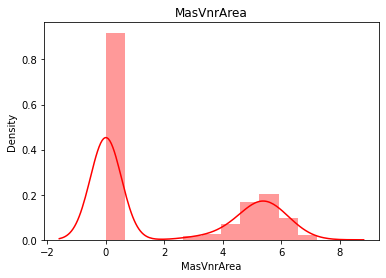

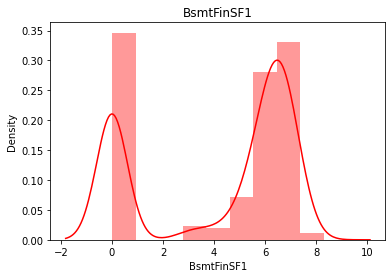

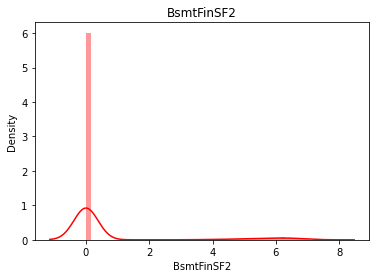

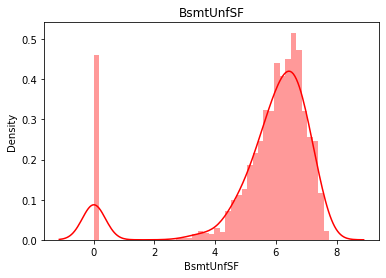

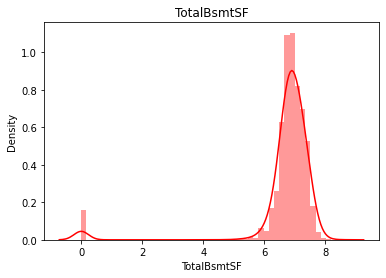

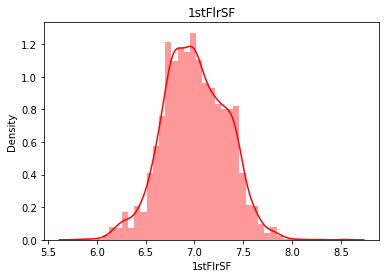

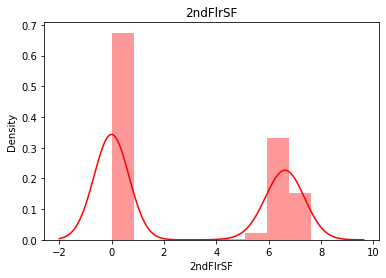

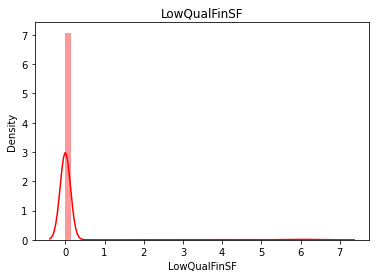

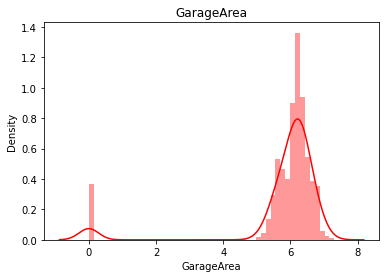

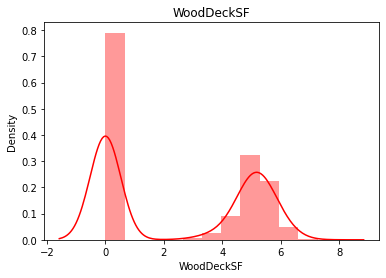

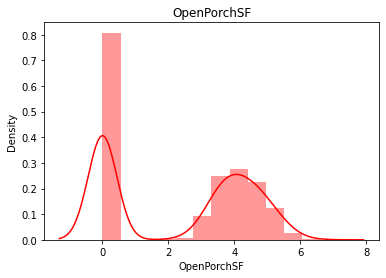

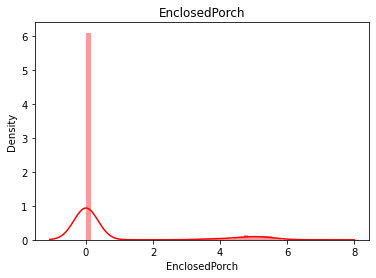

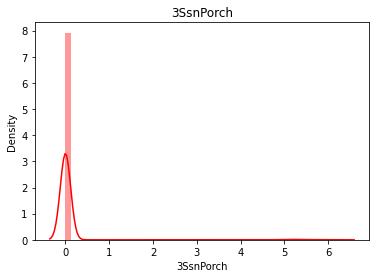

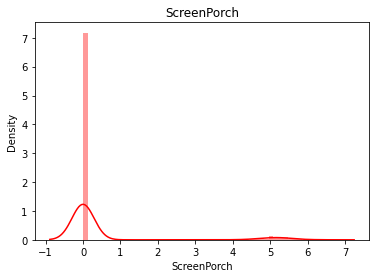

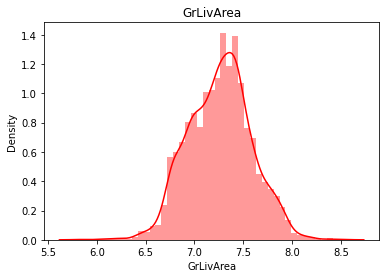

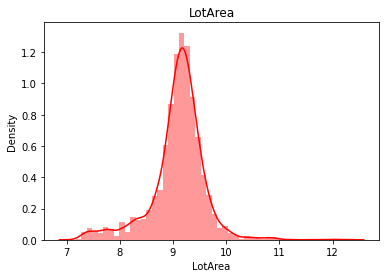

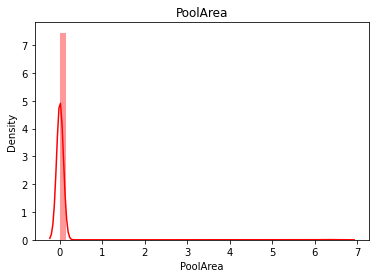

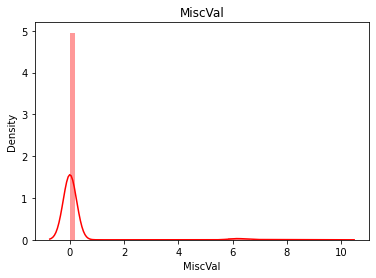

In [63]:
# expontential ==> log
for i in list(['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
               '1stFlrSF','2ndFlrSF','LowQualFinSF','GarageArea','WoodDeckSF',
               'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','GrLivArea',
               'LotArea','PoolArea','MiscVal']):
      dataframe[i]=(np.log1p(dataframe[i].dropna()))
# check result
for i in list(['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
               '1stFlrSF','2ndFlrSF','LowQualFinSF','GarageArea','WoodDeckSF',
               'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','GrLivArea',
               'LotArea','PoolArea','MiscVal']):
    sns.distplot(dataframe[i].dropna(),color='red').set_title(i)
    plt.show()

### 4.4 Oridinal Variables

In [64]:
for i in ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu',
          'GarageQual','GarageCond']:
      dataframe[i]=dataframe[i].replace(['Ex','Gd','TA','Fa','Po', 'none'], [5, 4, 3, 2, 1, 0]).astype(int)
    
for i in ['BsmtExposure']:
      dataframe[i]=dataframe[i].replace(['Gd','Av','Mn','No', 'none'], [4, 3, 2, 1, 0]).astype(int)
    
for i in ['BsmtFinType1','BsmtFinType2']:
      dataframe[i]=dataframe[i].replace(['GLQ','ALQ','BLQ','Rec', 'LwQ','Unf','none'], [6, 5, 4, 3, 2, 1, 0]).astype(int)


In [65]:
dataframe['House_year']=dataframe['YrSold']-dataframe['YearBuilt']
dataframe['Remod_year']=dataframe['YrSold']-dataframe['YearRemodAdd']
dataframe['Garage_built']=dataframe['YrSold']-dataframe['GarageYrBlt']


### 4.5 Categorical Variables

In [66]:
for i in ['YrSold','MSSubClass','MoSold']:
      dataframe[i]=dataframe[i].astype(str)
data_final=pd.get_dummies(dataframe)
data_final=data_final.drop(['Id'],axis=1).reset_index(drop=True)


### 4.6 Split the data into train /val set

In [67]:
x = data_final[:1453].drop('SalePrice', axis=1)
y = np.array(np.log1p(data_remove_outlier['SalePrice']))
test = data_final[1453:].drop('SalePrice', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size = .3, random_state=321)



## 5 Build Model

### 5.1 Ridge Regression

In [68]:
alpha=[0.0001,0.001,0.01,0.1,1,10,100]

Ridge = RidgeCV(cv=5, alphas=alpha,normalize=True)
Ridge_fit=Ridge.fit(x_train,y_train)
y_ridge_train=Ridge_fit.predict(x_train)
y_ridge_test=Ridge_fit.predict(x_test)


In [69]:
print('RMSE_train_Ridge = ' + str(math.sqrt(mean_squared_error(y_train, y_ridge_train))))
print('RMSE_test_Ridge = ' + str(math.sqrt(mean_squared_error(y_test, y_ridge_test))))

RMSE_train_Ridge = 0.09573968261576198
RMSE_test_Ridge = 0.1169750299134618


### 5.2 Lasso Regression

In [70]:
alpha=[0.0001,0.001,0.01,0.1,1,10,100]
Lasso = LassoCV(cv=5, alphas=alpha,normalize=True)
Lasso_fit=Lasso.fit(x_train,y_train)
y_lasso_train=Lasso_fit.predict(x_train)
y_lasso_test=Lasso_fit.predict(x_test)


In [71]:
print('RMSE_train_Lasso = ' + str(math.sqrt(mean_squared_error(y_train, y_lasso_train))))
print('RMSE_test_Lasso = ' + str(math.sqrt(mean_squared_error(y_test, y_lasso_test))))

RMSE_train_Lasso = 0.10153609532527076
RMSE_test_Lasso = 0.11054838867336636


### 5.3 ElasticNet

In [72]:
alpha=[0.0001,0.001,0.01,0.1,1,10,100]
l1ratio = [0.1, 0.5, 0.9, 0.95, 0.99, 1]
# find the best alpha/l1ratio and build model
elastic_cv = ElasticNetCV(cv=5, max_iter=1e7, alphas=alpha,  l1_ratio=l1ratio,normalize=True)
elastic_fit = elastic_cv.fit(x_train, y_train)
y_el_train=elastic_fit.predict(x_train)
y_el_test=elastic_fit.predict(x_test)


In [73]:
print('RMSE_train_ElasticNet = ' + str(math.sqrt(mean_squared_error(y_train, y_el_train))))
print('RMSE_test_ElasticNet = ' + str(math.sqrt(mean_squared_error(y_test, y_el_test))))


RMSE_train_ElasticNet = 0.10153609532527076
RMSE_test_ElasticNet = 0.11054838867336636


### 5.4 XGBoost

In [75]:
"""
estimator=XGBRegressor()
parameter_grid={
        'tree_method': ['gpu_hist'],
        'max_depth':range(2, 5, 1),
        'learning_rate':np.linspace(0.001, 1, 20),
        'colsample_bytree':np.linspace(0.1, 0.99, 20),
        'num_leaves':range(100, 200, 5),
        'n_estimators':range(100, 5000, 100)}
grid = RandomizedSearchCV(estimator, parameter_grid,cv = 2, scoring = 'neg_root_mean_squared_error',n_iter=500,n_jobs = -1)
grid.fit(x_train, y_train)
# print best parameter combination
print (grid.best_params_) 
"""

"\nestimator=XGBRegressor()\nparameter_grid={\n        'tree_method': ['gpu_hist'],\n        'max_depth':range(2, 5, 1),\n        'learning_rate':np.linspace(0.001, 1, 20),\n        'colsample_bytree':np.linspace(0.1, 0.99, 20),\n        'num_leaves':range(100, 200, 5),\n        'n_estimators':range(100, 5000, 100)}\ngrid = RandomizedSearchCV(estimator, parameter_grid,cv = 2, scoring = 'neg_root_mean_squared_error',n_iter=500,n_jobs = -1)\ngrid.fit(x_train, y_train)\n# print best parameter combination\nprint (grid.best_params_) \n"

In [77]:
xgb= XGBRegressor(base_score=0.5, 
                  tree_method='gpu_hist',
                  booster='gbtree', 
                  colsample_bylevel=1,
                  colsample_bynode=1, 
                  colsample_bytree=0.7, 
                  gamma=0,
                  importance_type='gain', 
                  learning_rate=0.01,
                  max_delta_step=0,
                  max_depth=3, 
                  min_child_weight=0, 
                  missing=None, 
                  n_estimators=1000,
                  n_jobs=1, 
                  nthread=None, 
                  objective='reg:squarederror', 
                  random_state=0,
                  reg_alpha=1, 
                  reg_lambda=1, 
                  scale_pos_weight=1, 
                  seed=None,
                  silent=None, 
                  subsample=1, 
                  verbosity=1)
xgb_fit = xgb.fit(x_train, y_train)
y_xgb_train=xgb_fit.predict(x_train)
y_xgb_test=xgb_fit.predict(x_test)

In [79]:
print('RMSE_train_LGBM = ' + str(math.sqrt(mean_squared_error(y_train, y_xgb_train))))
print('RMSE_test_LGBM = ' + str(math.sqrt(mean_squared_error(y_test, y_xgb_test))))

RMSE_train_LGBM = 0.09264070764189689
RMSE_test_LGBM = 0.12963469967081928


## 6 Stacking

In [80]:
# Build Model
gbdt=GradientBoostingRegressor(learning_rate=0.05,
                               max_leaf_nodes=3,
                              n_estimators=100)
stregr = StackingRegressor(regressors=[Ridge_fit, Lasso_fit, elastic_fit,xgb_fit], 
                           meta_regressor=gbdt, 
                           use_features_in_secondary=True)
stack_mod=stregr.fit(x_train, y_train.ravel())
# predict train/test y
stacking_pred_train=stack_mod.predict(x_train)
stacking_pred_test=stack_mod.predict(x_test)

In [81]:
# validation( train data and validate data)
print('RMSE_train_Stacking = ' + str(math.sqrt(mean_squared_error(y_train, stacking_pred_train))))
print('RMSE_test_Stacking = ' + str(math.sqrt(mean_squared_error(y_test, stacking_pred_test))))


RMSE_train_Stacking = 0.08041857217528679
RMSE_test_Stacking = 0.1199241273984112


### 7 Voting

In [83]:
from sklearn.ensemble import VotingRegressor
# Build Model
vote_mod = VotingRegressor([('Ridge', Ridge_fit), ('Lasso', Lasso_fit), ('Elastic', elastic_fit), ('xgb',xgb_fit)])
vote= vote_mod.fit(x_train, y_train.ravel())
# predict train/test y
vote_pred_train=vote.predict(x_train)
vote_pred_test=vote.predict(x_test)
# validation( train data and validate data)


In [84]:
print('RMSE_train_Voting = ' + str(math.sqrt(mean_squared_error(y_train, vote_pred_train))))
print('RMSE_test_Voting = ' + str(math.sqrt(mean_squared_error(y_test, vote_pred_test))))

RMSE_train_Voting = 0.09358079509147917
RMSE_test_Voting = 0.11157396764087482
